In [325]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import itertools

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [326]:
def read_data_and_create_df(data_file_path):
    df = pd.read_csv(data_file_path)
    return df

def convert_df_for_SARIMAX(orig_df, acc_num):
    df_one_acc_rev = orig_df[orig_df["ACCOUNT_NUMBER"].isin(acc_num)]
    df_one_acc_rev.drop(["CODE_COMBINATION_ID", "ACCOUNT_NUMBER"], axis=1, inplace=True)
    df_one_acc_rev["LAST_UPDATE_DATE"] = pd.to_datetime(df_one_acc_rev["LAST_UPDATE_DATE"])
    df_one_acc_rev.sort_values("LAST_UPDATE_DATE")
    
    df_one_acc_rev_agg = df_one_acc_rev.groupby("LAST_UPDATE_DATE").agg({"ACCOUNTED_BAL_USD": ["sum"]})
    df_one_acc_rev_agg.columns = ["SUM_OF_ACCOUNTED_BAL_USD"]

    df_one_acc_rev_agg = df_one_acc_rev_agg.reset_index()

    df_one_acc_rev_agg["LAST_UPDATE_DATE"] = pd.to_datetime(df_one_acc_rev_agg["LAST_UPDATE_DATE"])

    df_one_acc_rev_agg = df_one_acc_rev_agg.set_index("LAST_UPDATE_DATE")
    return df_one_acc_rev_agg

def create_SARIMAX_target(sarimax_df):
    return sarimax_df["SUM_OF_ACCOUNTED_BAL_USD"].resample("MS").mean()

def calculate_SARIMAX_estimation_params(y):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    min_aic = 0
    p_ = None
    sp_ = None
    cnt = 0
    res_data = []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y, paramer=param, 
                                                seasonal_order=param_seasonal, 
                                                enforce_stationarity=False,
                                                enforce_invertibility=False
                                               )
                results = mod.fit()
#                 print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
                if cnt == 0:
                    min_aic = results.aic
                    cnt += 1
                else:
                    if results.aic <= min_aic:
                        min_aic = results.aic
                        p_ = param
                        sp_ = param_seasonal
            except:
                continue            
        res_data.append((p_, sp_))
    return min_aic, res_data


def fit_SARIMAX(y, order, seasonal_order, enforce_stationarity=False, enforce_invertibility=False):
    mod = sm.tsa.statespace.SARIMAX(y, order=order, seasonal_order=seasonal_order, enforce_stationarity=enforce_stationarity, enforce_invertibility=enforce_invertibility)
    return mod.fit()


def generate_prediction(model, start_date, dynamic=False):
    pred = model.get_prediction(start=pd.to_datetime(start_date), dynamic=dynamic)
    return pred

def calc_RMSE(y_forecasted, y_truth):
    mse = ((y_forecasted - y_truth) ** 2).mean()
    return round(np.sqrt(mse), 2)

In [327]:
orig_df = read_data_and_create_df("final_data.csv")

In [328]:
sarimax_df = convert_df_for_SARIMAX(orig_df, [4004])

In [246]:
y = create_SARIMAX_target(sarimax_df)

In [247]:
min_aic, res = calculate_SARIMAX_estimation_params(y)

In [172]:
accs = [4004, 4603, 4654, 5001, 5017, 5201, 5211, 5293, 5575, 5401, 5476]
result_df = {"acc_num": [], "best_param": [], "best_seasonal_param": [], "rmse": []}
for a in accs:
    sdf = convert_df_for_SARIMAX(orig_df, [a])
    y_ = create_SARIMAX_target(sdf)
    min_aic, res = calculate_SARIMAX_estimation_params(y_)
    min_rmse = None
    p_ = None
    sp_ = None
    for param, seasonal_param in res:
        model = fit_SARIMAX(y_, param, seasonal_param)
        predictions = generate_prediction(model, '2017-01-01')
        RMSE = calc_RMSE(predictions.predicted_mean, y_['2017-01-01':])
        if min_rmse:
            if RMSE <= min_rmse:
                print(min_rmse)
                min_rmse = RMSE
                p_ = param
                sp_ = seasonal_param
        else:
            min_rmse = RMSE if not np.isnan(RMSE) else None
#             print(f"RMSE {RMSE} and min_rmse {min_rmse}")
    if p_ and sp_:
        result_df["acc_num"].append(a)
        result_df["best_param"].append(p_)
        result_df["best_seasonal_param"].append(sp_)
        result_df["rmse"].append(min_rmse)

resdf = pd.DataFrame.from_dict(result_df)
resdf.head()

24988660.44
20907441.39
18933503.25
390359.23
372294.26
164529.44
64860.07
63418.81
62605.85
62535.13
109358.28
10987.9
10966.39
1270432.17
1229104.04
364284.71


,acc_num,best_param,best_seasonal_param,rmse
0,4004,"(0, 1, 1)","(1, 1, 1, 12)",21014459.87
1,4603,"(1, 0, 0)","(1, 1, 1, 12)",13234263.45
2,4654,"(1, 1, 1)","(1, 1, 1, 12)",335941.62
3,5017,"(0, 1, 1)","(1, 1, 0, 12)",155111.85
4,5201,"(1, 1, 1)","(1, 1, 0, 12)",59825.91


In [174]:
resdf.to_csv("rmse_SARIMAX.csv", index=False)

## Prophet

In [329]:
sarimax_df = sarimax_df.reset_index()

In [330]:
sarimax_df.head()

,LAST_UPDATE_DATE,SUM_OF_ACCOUNTED_BAL_USD
0,2015-02-10,30335174.88
1,2015-02-11,5133911.34
2,2015-02-12,2648333.37
3,2015-02-13,5468768.35
4,2015-02-14,4644743.41


In [331]:
from fbprophet import Prophet

In [332]:
sarimax_df = sarimax_df.rename(columns={'LAST_UPDATE_DATE': 'ds', 'SUM_OF_ACCOUNTED_BAL_USD': 'y'})
sarimax_df.head()
# sarimax_df['cap'] = 8.5

,ds,y
0,2015-02-10,30335174.88
1,2015-02-11,5133911.34
2,2015-02-12,2648333.37
3,2015-02-13,5468768.35
4,2015-02-14,4644743.41


In [333]:
sarimax_df['y_orig'] = sarimax_df['y']
sarimax_df['y'] = np.log(sarimax_df['y'])
sarimax_df.head()

,ds,y,y_orig
0,2015-02-10,17.227818,30335174.88
1,2015-02-11,15.451378,5133911.34
2,2015-02-12,14.789441,2648333.37
3,2015-02-13,15.514564,5468768.35
4,2015-02-14,15.351247,4644743.41


In [335]:
sarimax_df.shape

(1294, 3)

In [337]:
sarimax_df.replace([np.inf, -np.inf], np.nan, inplace=True)
sarimax_df.dropna(subset=["y"], how='all')
sarimax_df.shape

(1294, 3)

In [338]:
m = Prophet(interval_width=0.95)
m.fit(sarimax_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [340]:
future = m.make_future_dataframe(periods=6, freq = 'm')
# future['cap'] = 8.5
future.tail()

,ds
1295,2019-03-31
1296,2019-04-30
1297,2019-05-31
1298,2019-06-30
1299,2019-07-31


In [341]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2015-02-10,14.776182,11.998523,17.598675
1,2015-02-11,15.414320,12.638048,18.104098
2,2015-02-12,14.514720,11.898494,17.298607
3,2015-02-13,15.569188,12.831103,18.182690
4,2015-02-14,15.298798,12.571784,18.000680


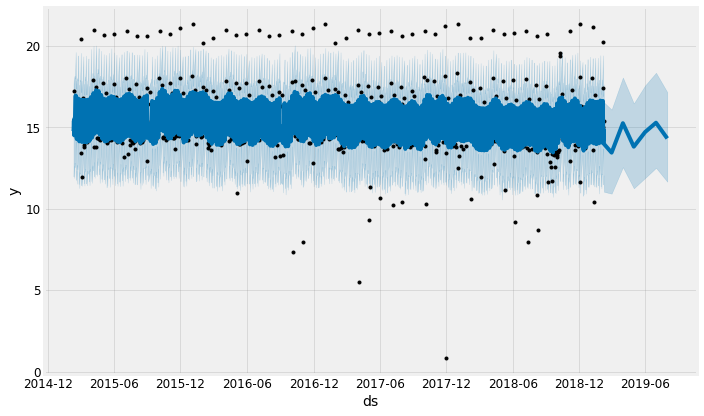

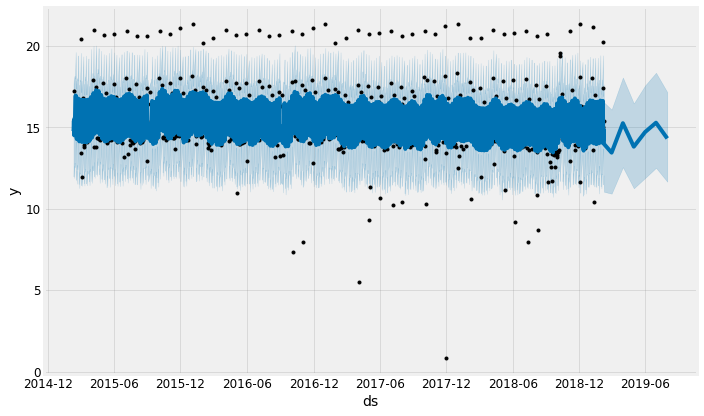

In [343]:
m.plot(forecast)

In [344]:
forecast.loc[:, 'yhat'][:505]

0      14.776182
1      15.414320
2      14.514720
3      15.569188
4      15.298798
         ...    
500    14.410566
501    15.076210
502    14.200876
503    14.291344
504    14.931192
Name: yhat, Length: 505, dtype: float64

In [345]:
sarimax_df.loc[:, "y"]

0       17.227818
1       15.451378
2       14.789441
3       15.514564
4       15.351247
          ...    
1289    17.444409
1290    20.242494
1291    15.046271
1292          NaN
1293    15.385580
Name: y, Length: 1294, dtype: float64

In [346]:
se = np.square(forecast.loc[:, 'yhat'][:505] - sarimax_df.loc[:, "y"])

In [347]:
mse = np.mean(se)
rmse = np.sqrt(mse)
rmse

1.1991851707735557

In [348]:
metric_df = forecast.set_index('ds')[['yhat']].join(sarimax_df.set_index('ds').y).reset_index()

In [349]:
metric_df.head()

,ds,yhat,y
0,2015-02-10,14.776182,17.227818
1,2015-02-11,15.414320,15.451378
2,2015-02-12,14.514720,14.789441
3,2015-02-13,15.569188,15.514564
4,2015-02-14,15.298798,15.351247


In [350]:
metric_df.dropna(inplace=True)

In [351]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [352]:
r2_score(metric_df.y, metric_df.yhat)

0.286762351424926

In [353]:
mean_squared_error(metric_df.y, metric_df.yhat)

1.9595802840975283

In [354]:
mean_absolute_error(metric_df.y, metric_df.yhat)

0.8657633328132699